# Speech emotion recognition using 1-dimensional ConvNN followed by Bi-lstm, and using transfer learing


#### First, lets define SER i.e. Speech Emotion Recognition.

*Speech Emotion Recognition*, abbreviated as *SER*, is the act of attempting to recognize human emotion and affective states from speech.
This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon
that animals like dogs and horses employ to be able to understand human emotion


## Importing libraries

In [2]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools

In [3]:
from glob import glob
from pathlib import Path
import random
from keras.layers import LSTM, Bidirectional
from keras.layers import *

In [4]:
pd.set_option('display.max_colwidth',None)

In [5]:
# Paths to
Ravdess = "../input/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24"
Crema = "../input/speech-emotion-recognition-en/Crema"
Savee = "../input/speech-emotion-recognition-en/Savee"
Tess = "../input/speech-emotion-recognition-en/Tess"

LAS = "../input/leaalasear/LeAalaSear"
SES = "../input/sa7ebels3adaa/sa7ebels3adaa"
EYASE = "../input/eyasedataset/EYASE"
SA = "../input/suits-arabic/Suits_Arabic"

## Data preparation

### LAS dataset

In [6]:
las_directory_list = os.listdir(LAS)

emotion_df = []

for dir in las_directory_list:
    actor = os.listdir(os.path.join(LAS, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("_")
        if info[1] == 'Sad' or info[1] == 'sad':
            emotion_df.append(("sad", os.path.join(LAS, dir, wav)))
        elif info[1] == 'Angry' or info[1] == 'angry':
            emotion_df.append(("angry", os.path.join(LAS, dir, wav)))
        elif info[1] == 'Surprised' or info[1] == 'surprised':
            emotion_df.append(("surprised", os.path.join(LAS, dir, wav)))
        elif info[1] == 'Fearful' or info[1] == 'fearful':
            emotion_df.append(("fearful", os.path.join(LAS, dir, wav)))
        elif info[1] == 'Happy' or info[1] == 'happy':
            emotion_df.append(("happy", os.path.join(LAS, dir, wav)))
        elif info[1] == 'Neutral' or info[1] == 'neutral':
            emotion_df.append(("neutral", os.path.join(LAS, dir, wav)))
        else:
            emotion_df.append(("unknown", os.path.join(LAS, dir, wav)))


LAS_df = pd.DataFrame.from_dict(emotion_df)
LAS_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

LAS_df.head()

Emotion  \
0      angry   
1    neutral   
2        sad   
3  surprised   
4      happy   

                                                                   Path  
0    ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_angry_1.wav  
1  ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_neutral_1.wav  
2      ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_sad_1.wav  
3  ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Surprised_1.wav  
4      ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_3.wav

In [10]:
LAS_df.shape
# pd.set_option('display.max_colwidth',None)

(675, 2)

### SES dataset

In [8]:
# # iterate over files in
# # that directory
# for filename in os.scandir(directory):
#     if filename.is_file():
#         print(filename.path)

        
# files = Path(directory).glob('*')
# for file in files:
#     print(file)


ses_directory_list = os.listdir(SES)

emotion_df = []

for dir in ses_directory_list:
    tmp=dir
    files = Path(SES).glob(tmp)
    for file in files:
#         print(file)
        actor = os.listdir(os.path.join(SES, dir))
#         print(actor)
        for emo in actor:
            files2 = Path(file).glob(emo)
            for fold in files2:
#                 print(fold)
                for wav in os.listdir(fold):
#                     print(wav)
                    info = wav.partition(".wav")[0].split("_")
                    if info[1] == 'Sad' or info[1] == 'sad':
                        emotion_df.append(("sad", os.path.join(fold, wav)))
                    elif info[1] == 'Angry' or info[1] == 'angry':
                        emotion_df.append(("angry", os.path.join(fold, wav)))
                    elif info[1] == 'Surprised' or info[1] == 'surprised':
                        emotion_df.append(("surprised", os.path.join(fold, wav)))
                    elif info[1] == 'Fearful' or info[1] == 'fearful':
                        emotion_df.append(("fearful", os.path.join(fold, wav)))
                    elif info[1] == 'Happy' or info[1] == 'happy':
                        emotion_df.append(("happy", os.path.join(fold, wav)))
                    elif info[1] == 'Neutral' or info[1] == 'neutral':
                        emotion_df.append(("neutral", os.path.join(fold, wav)))
                    else:
                        emotion_df.append(("unkown", os.path.join(fold, wav)))


SES_df = pd.DataFrame.from_dict(emotion_df)
SES_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

SES_df.head()

Emotion  \
0  fearful   
1  fearful   
2  fearful   
3  fearful   
4  fearful   

                                                                               Path  
0  ../input/sa7ebels3adaa/sa7ebels3adaa/LailaArabi/Fearful/LailaArabi_Fearful_5.wav  
1  ../input/sa7ebels3adaa/sa7ebels3adaa/LailaArabi/Fearful/LailaArabi_Fearful_6.wav  
2  ../input/sa7ebels3adaa/sa7ebels3adaa/LailaArabi/Fearful/LailaArabi_Fearful_3.wav  
3  ../input/sa7ebels3adaa/sa7ebels3adaa/LailaArabi/Fearful/LailaArabi_Fearful_1.wav  
4  ../input/sa7ebels3adaa/sa7ebels3adaa/LailaArabi/Fearful/LailaArabi_Fearful_2.wav

In [9]:
SES_df.shape

(910, 2)

### SA Dataset

In [11]:
sa_directory_list = os.listdir(SA)

emotion_df = []

for dir in sa_directory_list:
    tmp=dir
    files = Path(SA).glob(tmp)
    for file in files:
#         print(file)
        actor = os.listdir(os.path.join(SA, dir))
#         print(actor)
        for emo in actor:
            files2 = Path(file).glob(emo)
            for fold in files2:
#                 print(fold)
                for wav in os.listdir(fold):
#                     print(wav)
                    info = wav.partition(".wav")[0].split("_")
                    if info[1] == 'Sad' or info[1] == 'sad':
                        emotion_df.append(("sad", os.path.join(fold, wav)))
                    elif info[1] == 'Angry' or info[1] == 'angry':
                        emotion_df.append(("angry", os.path.join(fold, wav)))
                    elif info[1] == 'Surprised' or info[1] == 'surprised':
                        emotion_df.append(("surprised", os.path.join(fold, wav)))
                    elif info[1] == 'Fearful' or info[1] == 'fearful':
                        emotion_df.append(("fearful", os.path.join(fold, wav)))
                    elif info[1] == 'Happy' or info[1] == 'happy':
                        emotion_df.append(("happy", os.path.join(fold, wav)))
                    elif info[1] == 'Neutral' or info[1] == 'neutral':
                        emotion_df.append(("neutral", os.path.join(fold, wav)))
                    else:
                        emotion_df.append(("unkown", os.path.join(fold, wav)))


SA_df = pd.DataFrame.from_dict(emotion_df)
SA_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

SA_df.head()

Emotion  \
0    angry   
1  neutral   
2  neutral   
3  neutral   
4  neutral   

                                                                             Path  
0      ../input/suits-arabic/Suits_Arabic/LobnaWanas/Angry/LobnaWanas_Angry_1.wav  
1  ../input/suits-arabic/Suits_Arabic/LobnaWanas/Neutral/LobnaWanas_Neutral_2.wav  
2  ../input/suits-arabic/Suits_Arabic/LobnaWanas/Neutral/LobnaWanas_Neutral_3.wav  
3  ../input/suits-arabic/Suits_Arabic/LobnaWanas/Neutral/LobnaWanas_Neutral_4.wav  
4  ../input/suits-arabic/Suits_Arabic/LobnaWanas/Neutral/LobnaWanas_Neutral_1.wav

In [12]:
SA_df.shape

(585, 2)

### EYASE Dataset

In [13]:
eyase_directory_list = os.listdir(EYASE)

emotion_df = []

for dir in eyase_directory_list:
    actor = os.listdir(os.path.join(EYASE, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("_")
        emoInfo=info[1][0:3]
        if emoInfo == 'sad':
            emotion_df.append(("sad", os.path.join(EYASE, dir, wav)))
        elif emoInfo == 'ang':
            emotion_df.append(("angry", os.path.join(EYASE, dir, wav)))
        elif emoInfo == 'hap':
            emotion_df.append(("happy", os.path.join(EYASE, dir, wav)))
        elif emoInfo == 'neu':
            emotion_df.append(("neutral", os.path.join(EYASE, dir, wav)))
        else:
            emotion_df.append(("unknown", os.path.join(EYASE, dir, wav)))


EYASE_df = pd.DataFrame.from_dict(emotion_df)
EYASE_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

EYASE_df.head()

Emotion                                                    Path
0    angry  ../input/eyasedataset/EYASE/Female02/fm01_ang (20).wav
1  neutral  ../input/eyasedataset/EYASE/Female02/fm01_neu (17).wav
2      sad  ../input/eyasedataset/EYASE/Female02/fm01_sad (16).wav
3  neutral   ../input/eyasedataset/EYASE/Female02/fm01_neu (4).wav
4    happy  ../input/eyasedataset/EYASE/Female02/fm01_hap (13).wav

In [14]:
EYASE_df.shape

(579, 2)

In [15]:
EYASE_df=EYASE_df[EYASE_df['Emotion']!="happy"]

In [16]:
EYASE_df[EYASE_df.Emotion=="happy"]

Empty DataFrame
Columns: [Emotion, Path]
Index: []

In [17]:
EYASE_df.head()

Emotion                                                    Path
0    angry  ../input/eyasedataset/EYASE/Female02/fm01_ang (20).wav
1  neutral  ../input/eyasedataset/EYASE/Female02/fm01_neu (17).wav
2      sad  ../input/eyasedataset/EYASE/Female02/fm01_sad (16).wav
3  neutral   ../input/eyasedataset/EYASE/Female02/fm01_neu (4).wav
6  neutral   ../input/eyasedataset/EYASE/Female02/fm01_neu (3).wav

In [18]:
EYASE_df.shape

(447, 2)

### Ravdess dataset

Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [ ]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [ ]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

### Crema dataset

In [ ]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

### TESS dataset

In [ ]:
tess_directory_list = os.listdir(Tess)
# print(tess_directory_list)

emotion_df = []

for dir in tess_directory_list:
#     print(dir)
    for wav in os.listdir(os.path.join(Tess, dir)):
#         print(wav)
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

### Savee dataset

The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + "/" + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + "/" + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + "/" + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + "/" + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + "/" + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + "/" + wav))
    else:
        emotion_df.append(("surprise", Savee + "/" + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

In [ ]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

In [ ]:
df = pd.concat([LAS_df, SES_df], axis=0)
df.shape

In [19]:
df = pd.concat([LAS_df, SES_df, SA_df, EYASE_df], axis=0)
df.shape

(2617, 2)

In [20]:
df.head(10)

Emotion  \
0      angry   
1    neutral   
2        sad   
3  surprised   
4      happy   
5    neutral   
6        sad   
7    neutral   
8    neutral   
9    neutral   

                                                                   Path  
0    ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_angry_1.wav  
1  ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_neutral_1.wav  
2      ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_sad_1.wav  
3  ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Surprised_1.wav  
4      ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_3.wav  
5   ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_neutral_10.wav  
6        ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Sad_3.wav  
7    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_neutral_7.wav  
8    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Neutral_4.wav  
9    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Neutral_3.wav

### Due to i don't split the dataset by gender, let's look at distribution by


In [21]:
%matplotlib inline

plt.style.use("ggplot")

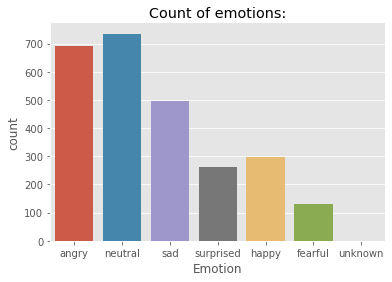

In [22]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [23]:
df[df.Emotion=="unknown"]

Emotion  \
536  unknown   

                                                                   Path  
536  ../input/leaalasear/LeAalaSear/NellyKarim/NellyKarim_Surprise_.wav

In [24]:
df=df[df['Emotion']!="unknown"]

In [25]:
# df=df[df['Emotion']!="surprised"]
df=df[df['Emotion']!="fearful"]

In [28]:
# ['angry','happy','neutral','sad']
df=df[df['Emotion']!="surprise"]
df=df[df['Emotion']!="fear"]
df=df[df['Emotion']!="disgust"]


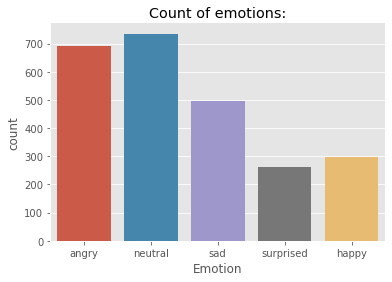

In [26]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [27]:
df.shape

(2485, 2)

In [28]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

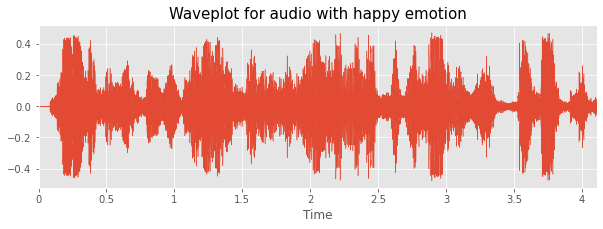

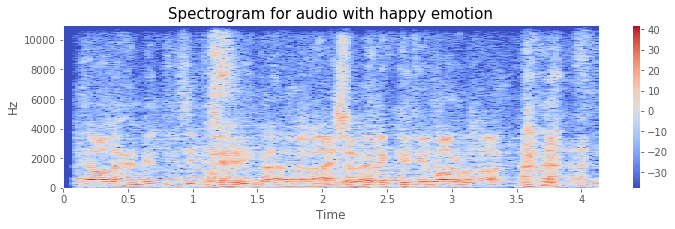

In [32]:
emotion='happy'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

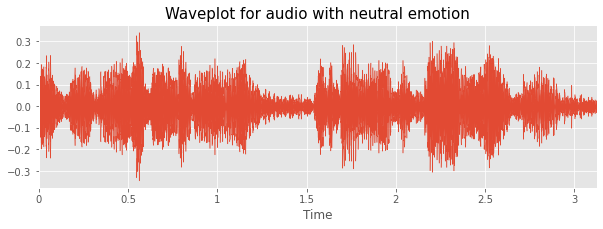

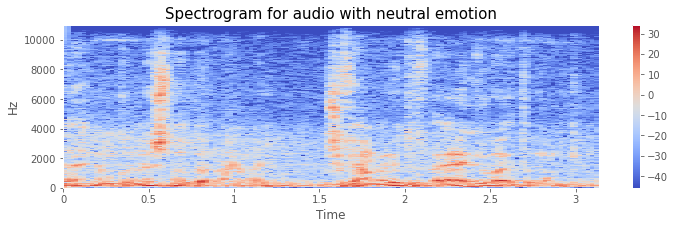

In [50]:
emotion='neutral'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [51]:
emotion='surprised'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

IndexError: index 1 is out of bounds for axis 0 with size 0

In [ ]:
emotion='fearful'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


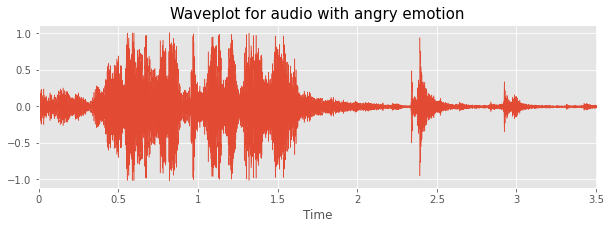

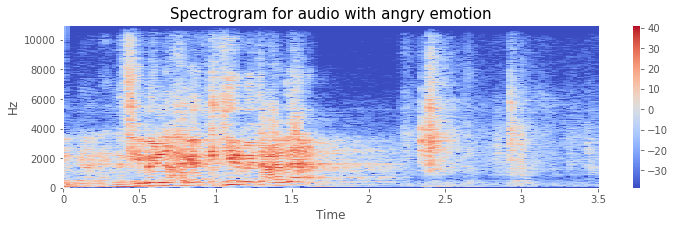

In [52]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

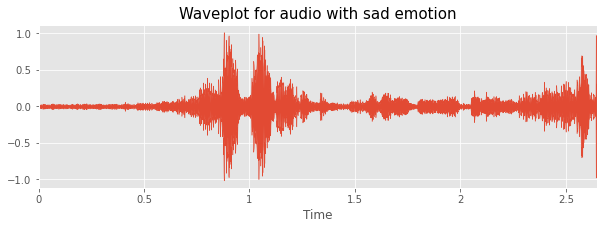

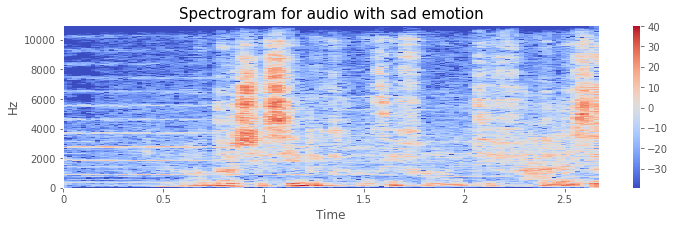

In [53]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [29]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [34]:
df.head()

Emotion  \
0    angry   
1  neutral   
2      sad   
4    happy   
5  neutral   

                                                                   Path  
0    ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_angry_1.wav  
1  ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_neutral_1.wav  
2      ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_sad_1.wav  
4      ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_3.wav  
5   ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_neutral_10.wav

In [30]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple audio

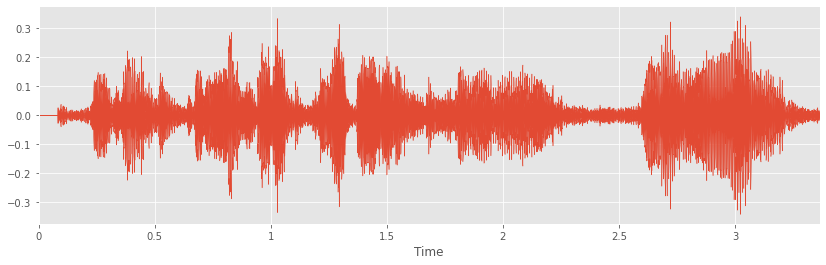

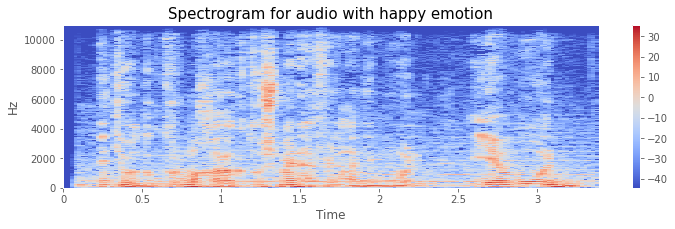

In [31]:
e= "happy"
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate, e)
Audio(path)

2. Noised audio

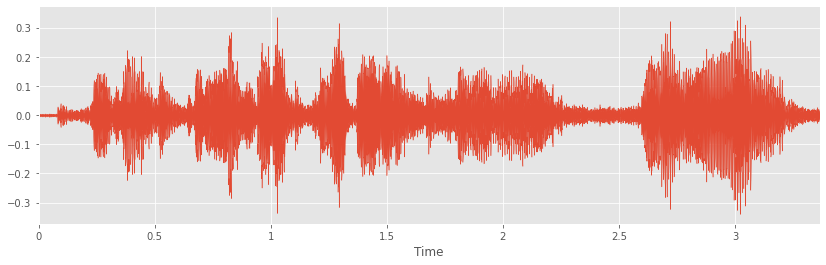

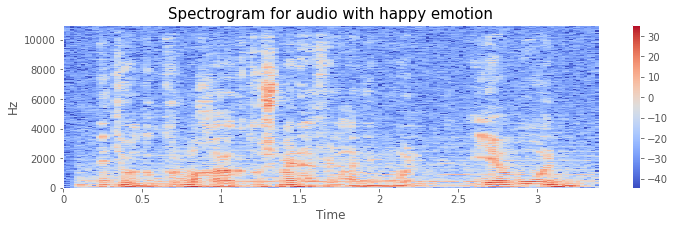

In [32]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
e= "happy"
create_spectrogram(noised_data, sampling_rate, e)
Audio(noised_data, rate=sampling_rate)



3. Stretching


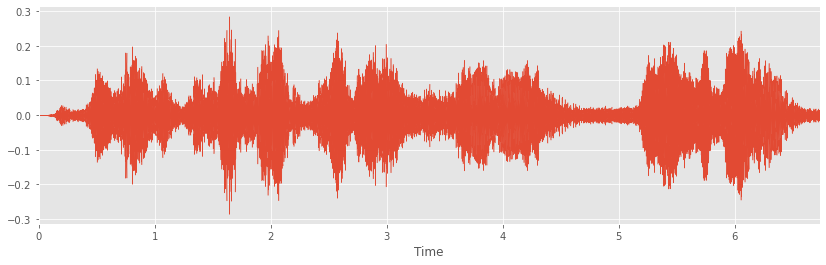

In [59]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)


4. Shifting


In [ ]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

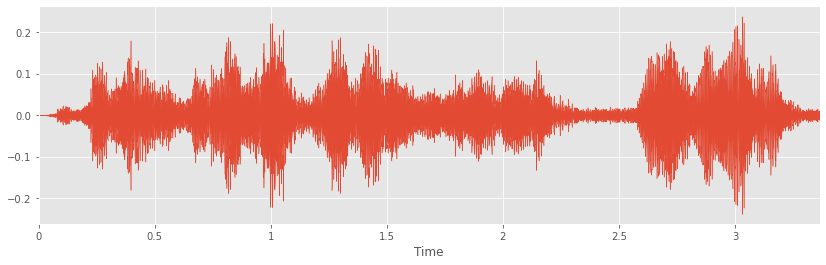

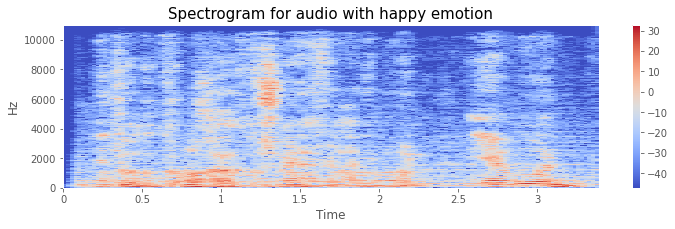

In [60]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
e= "happy"
create_spectrogram(pitched_data, sampling_rate, e)
Audio(pitched_data, rate=sampling_rate)

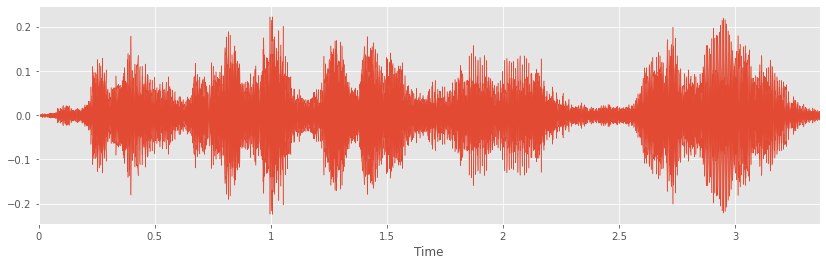

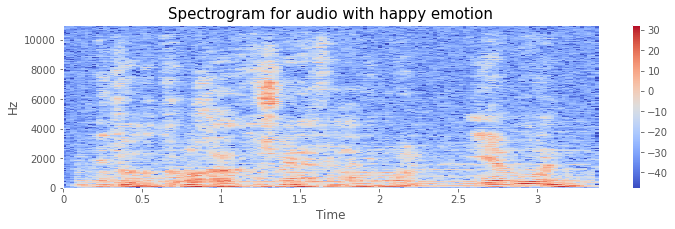

In [61]:
new_data = pitch(data, sampling_rate,pitch_factor=0.5, random=True)
data_noise_pitch = noise(new_data, random=True)

# pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data_noise_pitch, sr=sampling_rate)
e= "happy"
create_spectrogram(data_noise_pitch, sampling_rate, e)
Audio(data_noise_pitch, rate=sampling_rate)

For our data augmentation we will use noise and pitch and combination with both of it.


## Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [33]:
n_fft = 2048
hop_length = 512

In [34]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

#### Let's check data formats:

In [35]:
# traindf = df.iloc[:1267]
# traindf = df.iloc[:1087]




 
# Creating a dataframe with 80%
# values of original dataframe
# traindf = df.sample(frac = 0.8)

# d = {'id': [1,2,3,3,4,5,6,7,7,7,8,9,10,10], 'col2': [3,4,5,7,8,9,1,5,9,10,11,4,1,7]}
# df = pd.DataFrame(data=d)

len_per = int(len(set(df['Path'])) / 100 * 20)
ids = random.sample(set(df["Path"]), len_per)

testdf = df[df["Path"].isin(ids)]
traindf = df[~df["Path"].isin(ids)]





In [36]:
traindf

Emotion  \
0        angry   
1      neutral   
2          sad   
3    surprised   
4        happy   
..         ...   
569        sad   
570    neutral   
571      angry   
575        sad   
576    neutral   

                                                                     Path  
0      ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_angry_1.wav  
1    ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_neutral_1.wav  
2        ../input/leaalasear/LeAalaSear/SarahHesham/SarahHesham_sad_1.wav  
3    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Surprised_1.wav  
4        ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_3.wav  
..                                                                    ...  
569                  ../input/eyasedataset/EYASE/Male01/ml01_sad (17).wav  
570                  ../input/eyasedataset/EYASE/Male01/ml01_neu (25).wav  
571                  ../input/eyasedataset/EYASE/Male01/ml01_ang (19).wav  
575                   ../input/eyasedataset/EYASE/Male01/ml01_sad (7).wav  
576                  ../input/eyasedataset/EYASE/Male01/ml01_neu (17).wav  

[1988 rows x 2 columns]

In [37]:
# testdf = df.iloc[1267:1584]
# testdf = df.iloc[1087:1358]


# Creating dataframe with
# rest of the 20% values
# testdf = df.drop(traindf.index)


testdf

Emotion  \
7    neutral   
8    neutral   
13     happy   
17   neutral   
23     happy   
..       ...   
546      sad   
547    angry   
553      sad   
572  neutral   
574    angry   

                                                                   Path  
7    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_neutral_7.wav  
8    ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Neutral_4.wav  
13     ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_4.wav  
17   ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Neutral_5.wav  
23     ../input/leaalasear/LeAalaSear/AhmedMagdy/AhmedMagdy_Happy_7.wav  
..                                                                  ...  
546                ../input/eyasedataset/EYASE/Male01/ml01_sad (22).wav  
547                 ../input/eyasedataset/EYASE/Male01/ml01_ang (1).wav  
553                ../input/eyasedataset/EYASE/Male01/ml01_sad (26).wav  
572                 ../input/eyasedataset/EYASE/Male01/ml01_neu (2).wav  
574                ../input/eyasedataset/EYASE/Male01/ml01_ang (30).wav  

[497 rows x 2 columns]

In [38]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=3, offset=0.1)
# data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

25187

In [39]:
Audio(data,rate=sample_rate)

In [41]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (50,)
Energy:  (50,)
Entropy of Energy : (50,)
RMS : (50,)
Spectral Centroid : (50,)
Spectral Flux:  ()
Spectral Rollof:  (50,)
Chroma STFT:  (600,)
MelSpectrogram:  (6400,)
MFCC:  (1000,)


In experimental way was decided to use just 3 main features for this task: *ZCR*, *RMS* and *MFCC*.

Also in experimental way  was decided to use just 3s duration with 0.1 offset - in the dataset first 0.1s contains
no information about emotion, and most of them are less then 3s.

In [42]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
#                         mel_spc(data, sr, frame_length, hop_length, flatten=True),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
#     print("from ext: ",result)
    return result

# New Part

In [43]:
def get_features_for_test(path, duration=3, offset=0.1):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     duration=librosa.get_duration(filename=path)
    data, sample_rate = librosa.load(path, duration=duration,offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
#     print("from getFtAll: ",result)
    return result

In [44]:
def get_features(path, duration=3, offset=0.1):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     duration=librosa.get_duration(filename=path)
    data, sample_rate = librosa.load(path, duration=duration,offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
#     print("from getFt: ",result)

    return result


In [45]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(traindf.Path, traindf.Emotion, range(traindf.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
Done.


Let's save our features as DataFrame for further processing:

### wihtout aug

In [ ]:
# X, Y = [], []
# print("Feature processing...")
# for path, emotion, ind in zip(traindf.Path, traindf.Emotion, range(traindf.Path.shape[0])):
#     features = get_features_for_test(path)
#     if ind % 100 == 0:
#         print(f"{ind} samples has been processed...")
# #     for ele in features:
#     X.append(features)
# #         print("this is x ",X)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#     Y.append(emotion)
# #     if ind == 0:
# #         newdf=pd.DataFrame(X)
# #     else:
# #         newdf=pd.append(X)
    
# print("Done.")

In [46]:
features_path = "./features1.csv"

In [47]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.035645  0.079590  0.129395  0.164551  0.209961  0.246582  0.266602   
1  0.048340  0.099121  0.151855  0.176270  0.214844  0.248535  0.270508   
2  0.044434  0.104980  0.154785  0.195801  0.225586  0.237793  0.267578   
3  0.044922  0.103027  0.150879  0.194824  0.221191  0.238770  0.268066   
4  0.030273  0.039062  0.049316  0.040039  0.038574  0.042969  0.043457   

          7         8         9  ...      2853       2854       2855  \
0  0.277344  0.245605  0.206543  ...  2.436264 -19.854900 -10.324333   
1  0.284180  0.255371  0.211426  ...  7.523567  -9.248133  -6.578746   
2  0.279297  0.265625  0.241699  ...  5.689411 -15.259886   9.637904   
3  0.274414  0.266602  0.236328  ...  4.092195 -21.587121  -8.089675   
4  0.060059  0.071289  0.075195  ...       NaN        NaN        NaN   

        2856       2857       2858       2859       2860       2861   labels  
0  15.211718  24.637514   7.310674 -15.503200 -21.481115 -24.373165    angry  
1  18.945804  28.793645  12.011945  -8.898215 -17.011448 -18.843170    angry  
2  15.633601  17.313366  -8.635866 -14.114903 -24.371418 -12.913696    angry  
3  20.183784  24.754824   6.665401 -11.999526 -15.226312 -17.095046    angry  
4        NaN        NaN        NaN        NaN        NaN        NaN  neutral  

[5 rows x 2863 columns]

In [48]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(7952, 2863)


In [49]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2858      False
2859      False
2860      False
2861      False
labels    False
Length: 2863, dtype: bool


(7952, 2863)

In [50]:
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.035645  0.079590  0.129395  0.164551  0.209961  0.246582  0.266602   
1  0.048340  0.099121  0.151855  0.176270  0.214844  0.248535  0.270508   
2  0.044434  0.104980  0.154785  0.195801  0.225586  0.237793  0.267578   
3  0.044922  0.103027  0.150879  0.194824  0.221191  0.238770  0.268066   
4  0.030273  0.039062  0.049316  0.040039  0.038574  0.042969  0.043457   

          7         8         9  ...      2853       2854       2855  \
0  0.277344  0.245605  0.206543  ...  2.436264 -19.854900 -10.324333   
1  0.284180  0.255371  0.211426  ...  7.523567  -9.248133  -6.578746   
2  0.279297  0.265625  0.241699  ...  5.689411 -15.259886   9.637904   
3  0.274414  0.266602  0.236328  ...  4.092195 -21.587121  -8.089675   
4  0.060059  0.071289  0.075195  ...  0.000000   0.000000   0.000000   

        2856       2857       2858       2859       2860       2861   labels  
0  15.211718  24.637514   7.310674 -15.503200 -21.481115 -24.373165    angry  
1  18.945804  28.793645  12.011945  -8.898215 -17.011448 -18.843170    angry  
2  15.633601  17.313366  -8.635866 -14.114903 -24.371418 -12.913696    angry  
3  20.183784  24.754824   6.665401 -11.999526 -15.226312 -17.095046    angry  
4   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000  neutral  

[5 rows x 2863 columns]

In [51]:
testX, testY = [], []
print("Feature processing...")
for path, emotion, ind in zip(testdf.Path, testdf.Emotion, range(testdf.Path.shape[0])):
    features = get_features_for_test(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
#     for ele in features:
    testX.append(features)
#         print("this is x ",X)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
    testY.append(emotion)
#     if ind == 0:
#         newdf=pd.DataFrame(X)
#     else:
#         newdf=pd.append(X)
    
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
Done.


In [52]:
features_path = "./featuresTest1.csv"

In [53]:
extracted_testdf = pd.DataFrame(testX)
extracted_testdf["labels"] = testY
extracted_testdf.to_csv(features_path, index=False)
extracted_testdf.head()

0         1         2         3         4         5         6  \
0  0.011719  0.018066  0.023926  0.024414  0.023438  0.020996  0.020020   
1  0.375977  0.431641  0.465332  0.312988  0.158203  0.144531  0.188965   
2  0.057129  0.098633  0.153809  0.186523  0.223633  0.264648  0.286621   
3  0.072754  0.109375  0.143555  0.141113  0.152344  0.146973  0.154297   
4  0.072266  0.087891  0.097656  0.064453  0.049805  0.044434  0.044434   

          7         8         9  ...  2853  2854  2855  2856  2857  2858  \
0  0.025879  0.028809  0.095215  ...   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.221680  0.245605  0.221191  ...   NaN   NaN   NaN   NaN   NaN   NaN   
2  0.298828  0.310547  0.308105  ...   NaN   NaN   NaN   NaN   NaN   NaN   
3  0.158203  0.137207  0.123535  ...   NaN   NaN   NaN   NaN   NaN   NaN   
4  0.052246  0.060059  0.072754  ...   NaN   NaN   NaN   NaN   NaN   NaN   

   2859  2860  2861   labels  
0   NaN   NaN   NaN  neutral  
1   NaN   NaN   NaN  neutral  
2   NaN   NaN   NaN    happy  
3   NaN   NaN   NaN  neutral  
4   NaN   NaN   NaN    happy  

[5 rows x 2863 columns]

In [54]:
extracted_testdf = pd.read_csv(features_path)
print(extracted_testdf.shape)

(497, 2863)


In [55]:
# Fill NaN with 0
extracted_testdf = extracted_testdf.fillna(0)
print(extracted_testdf.isna().any())
extracted_testdf.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2858      False
2859      False
2860      False
2861      False
labels    False
Length: 2863, dtype: bool


(497, 2863)

In [66]:
extracted_testdf.head()

0         1         2         3         4         5         6  \
0  0.011719  0.018066  0.023926  0.024414  0.023438  0.020996  0.020020   
1  0.375977  0.431641  0.465332  0.312988  0.158203  0.144531  0.188965   
2  0.057129  0.098633  0.153809  0.186523  0.223633  0.264648  0.286621   
3  0.072754  0.109375  0.143555  0.141113  0.152344  0.146973  0.154297   
4  0.072266  0.087891  0.097656  0.064453  0.049805  0.044434  0.044434   

          7         8         9  ...  2853  2854  2855  2856  2857  2858  \
0  0.025879  0.028809  0.095215  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.221680  0.245605  0.221191  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2  0.298828  0.310547  0.308105  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3  0.158203  0.137207  0.123535  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.052246  0.060059  0.072754  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   2859  2860  2861   labels  
0   0.0   0.0   0.0  neutral  
1   0.0   0.0   0.0  neutral  
2   0.0   0.0   0.0    happy  
3   0.0   0.0   0.0  neutral  
4   0.0   0.0   0.0    happy  

[5 rows x 2863 columns]

## Data preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [67]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [68]:
testX = extracted_testdf.drop(labels="labels", axis=1)
testY = extracted_testdf["labels"]

In [69]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y


['angry' 'happy' 'neutral' 'sad' 'surprised']


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [70]:
lb = LabelEncoder()
testY = np_utils.to_categorical(lb.fit_transform(testY))
print(lb.classes_)
testY


['angry' 'happy' 'neutral' 'sad' 'surprised']


array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [57]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [71]:
X_train = X
y_train = Y

X_test = testX
y_test = testY

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((7156, 2862), (497, 2862), (796, 2862), (7156, 5), (497, 5), (796, 5))

In [73]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((7156, 2862), (497, 2862), (796, 2862), (7156, 5), (497, 5), (796, 5))

In [74]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(7156, 2862, 1)

### Let's define our model:

In [75]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [76]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [77]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)) #cnn reshape
# X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) #lstm reshape
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
# X_train.shape, X_test.shape

In [80]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))




model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))



# model.add(Bidirectional(LSTM(512)))


model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))



# model.add(Bidirectional(LSTM(256)))


model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))



# model.add(Bidirectional(LSTM(256)))



model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))



model.add(Bidirectional(LSTM(128)))

# model.add(Attention(128))



model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(5, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])



In [ ]:
# model2 = models.Sequential()
# model2.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], 1)))
# model2.add(attention(636))
# model2.add(Dropout(0.2))
# model2.add(Dense(400))
# model2.add(Flatten())
# model2.add(Dropout(0.2)) 
# model2.add(Dense(6, activation='softmax'))
# model2.compile(loss='categorical_crossentropy',
#               optimizer=optimizer,
#               metrics=['acc'])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 2862, 512)         3072      
_________________________________________________________________
batch_normalization_6 (Batch (None, 2862, 512)         2048      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1431, 512)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1431, 512)         1311232   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1431, 512)         2048      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 716, 512)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 716, 256)         

In [82]:
EPOCHS = 50
batch_size = 64

In [83]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])
print("Done")

Epoch 1/50
112/112 [==============================] - 43s 381ms/step - loss: 1.7007 - acc: 0.3390 - val_loss: 1.5981 - val_acc: 0.2802
Epoch 2/50
112/112 [==============================] - 42s 375ms/step - loss: 1.3446 - acc: 0.4605 - val_loss: 1.5486 - val_acc: 0.3606
Epoch 3/50
112/112 [==============================] - 43s 383ms/step - loss: 1.2630 - acc: 0.4969 - val_loss: 1.9725 - val_acc: 0.3492
Epoch 4/50
112/112 [==============================] - 43s 381ms/step - loss: 1.1700 - acc: 0.5334 - val_loss: 1.3767 - val_acc: 0.4372
Epoch 5/50
112/112 [==============================] - 43s 382ms/step - loss: 1.0735 - acc: 0.5746 - val_loss: 1.7568 - val_acc: 0.3769
Epoch 6/50
112/112 [==============================] - 43s 381ms/step - loss: 0.9982 - acc: 0.6066 - val_loss: 0.9774 - val_acc: 0.6307
Epoch 7/50
112/112 [==============================] - 43s 381ms/step - loss: 0.9009 - acc: 0.6470 - val_loss: 1.0321 - val_acc: 0.6030
Epoch 8/50
112/112 [==============================] - 4

### Displaying the validation and training accuracies and losses

16/16 [==============================] - 1s 57ms/step - loss: 3.8405 - acc: 0.5091
Accuracy of our model on test data :  50.90543031692505 %


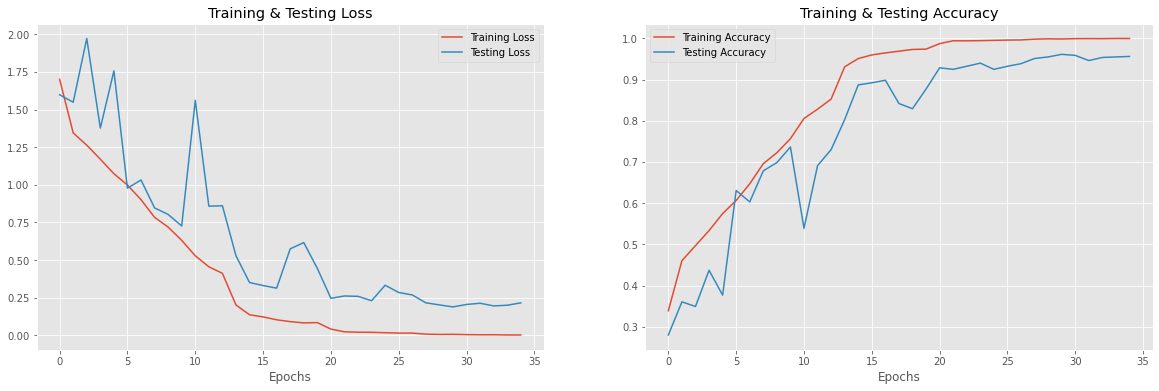

In [84]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [85]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([3, 1, 2, 1, 1, 1, 0, 4, 4, 4, 0, 2, 3, 0, 3, 3, 1, 0, 3, 3, 1, 4,
       4, 0, 0, 3, 0, 0, 0, 2, 0, 0, 1, 3, 3, 2, 3, 2, 2, 2, 3, 1, 2, 0,
       0, 4, 1, 0, 4, 0, 1, 2, 2, 1, 2, 1, 4, 3, 2, 0, 4, 1, 3, 0, 4, 3,
       3, 2, 1, 4, 0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 4, 3, 0, 1, 4, 0, 4, 0,
       2, 2, 4, 0, 0, 2, 0, 2, 2, 3, 0, 0, 3, 2, 0, 1, 0, 1, 2, 1, 0, 2,
       4, 3, 2, 0, 0, 1, 1, 1, 0, 2, 1, 4, 0, 1, 0, 2, 4, 1, 0, 4, 3, 0,
       2, 2, 3, 4, 4, 2, 2, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 3,
       2, 0, 2, 4, 0, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 0, 0,
       3, 3, 3, 3, 0, 3, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0, 3, 3, 2, 2, 2,
       2, 0, 0, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 0, 2, 2, 3, 2, 3,
       3, 0, 3, 2, 2, 2, 3, 2, 0, 3, 3, 2, 0, 0, 4, 4, 2, 2, 2, 3, 2, 1,
       0, 2, 0, 1, 0, 0, 1, 2, 3, 2, 4, 3, 2, 1, 0, 0, 4, 1, 1, 2, 0, 0,
       0, 0, 2, 0, 3, 2, 3, 2, 4, 0, 4, 0, 0, 2, 0,

In [86]:
y_check = np.argmax(y_test, axis=1)
y_check

array([2, 2, 1, 2, 1, 4, 1, 0, 4, 4, 0, 2, 2, 4, 3, 1, 4, 2, 2, 3, 1, 4,
       2, 0, 0, 4, 4, 0, 2, 4, 0, 0, 2, 3, 3, 2, 3, 2, 3, 1, 3, 0, 2, 1,
       0, 4, 4, 2, 4, 0, 3, 3, 1, 3, 3, 1, 1, 1, 1, 0, 4, 1, 4, 0, 3, 4,
       3, 4, 2, 3, 2, 0, 2, 1, 2, 1, 0, 0, 2, 0, 4, 3, 0, 4, 1, 3, 4, 0,
       3, 3, 1, 4, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 3, 3, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 4, 1, 1, 0, 1, 0, 0, 3, 1, 0, 3, 3, 1,
       2, 0, 0, 2, 2, 2, 2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 1, 1, 2, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 0, 2, 2, 0,
       2, 3, 3, 3, 3, 1, 0, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 4, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1, 1, 1, 3, 3, 3, 4,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 0, 0, 2, 2, 3, 1, 1, 2, 0, 0,
       0, 0, 3, 3, 3, 4, 4, 4, 4, 1, 1, 0, 0, 0, 0,

### Displaying confusion matrix of the predicted data

In [87]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [88]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[86  6 19  8 10]
 [20 16 14  6  9]
 [28 10 81 23  6]
 [11  5 22 43  8]
 [12  6 10 11 27]]


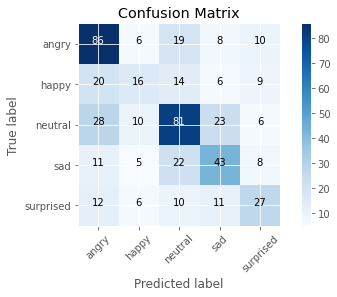

In [92]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=a, title='Confusion Matrix')

### Saving the model

In [91]:
path_to_model = "./res_model.h5"

model.save(path_to_model)

In [ ]:
# print(cm)
# cm_plot_labels.sort()
cm_plot_labels


In [93]:
from sklearn.metrics import  classification_report

### Classification report

In [94]:
print(classification_report(y_true=y_check, y_pred=y_pred, target_names=a))

              precision    recall  f1-score   support

       angry       0.55      0.67      0.60       129
       happy       0.37      0.25      0.30        65
     neutral       0.55      0.55      0.55       148
         sad       0.47      0.48      0.48        89
   surprised       0.45      0.41      0.43        66

    accuracy                           0.51       497
   macro avg       0.48      0.47      0.47       497
weighted avg       0.50      0.51      0.50       497



In [90]:
lb.classes_

array(['angry', 'happy', 'neutral', 'sad', 'surprised'], dtype=object)

In [91]:
# a=np.asarray(['angry','happy','neutral','sad'])

a=np.asarray(['angry','happy','neutral','sad','surprised' ])

# a=np.asarray(['angry','fearful','happy','neutral','sad', 'surprised'])

print(a)

['angry' 'happy' 'neutral' 'sad' 'surprised']


# Transfer Learning

In [ ]:
num_classes = 6
my_old_model = models.load_model('/kaggle/input/englishmodel/Emotion_Model.h5')
# my_new_model = models.Sequential()
# my_new_model.add(my_old_model(include_top=False, pooling='avg'))
# my_new_model.add(Dense(num_classes, activation='softmax'))

# # Say not to train first layer (ResNet) model. It is already trained
# my_new_model.layers[0].trainable = False

# my_new_model.summary()

In [71]:
# newmodel = models.load_model("/kaggle/working/res_model.h5",compile=False)
# newmodel = models.load_model("/kaggle/input/prevmodel/res_model (3).h5")
# newmodel = models.load_model("/kaggle/working/res_model.h5")
newmodel = models.load_model("/kaggle/input/prevmodel-4emo/res_model (4).h5")
newmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 594, 256)          6

#### Freezing the first 10 layers

In [72]:
for i in range(9):
    newmodel.layers[i].trainable = False

#### adding and removing some layers from the pretrained model

In [73]:
# ll = newmodel.add(layers.Conv1D(512, kernel_size=5, strides=1,
#                         padding="same", activation="relu",
#                         input_shape=(X_train.shape[1], 1)))
ll = newmodel.layers[14].output 

ll=LSTM(256)(ll)
ll= layers.Flatten()(ll)
ll= layers.Dense(128,activation="relu")(ll)
# ll= layers.BatchNormalization()(ll)
ll= layers.Dropout(rate=0.4)(ll)
ll = layers.Dense(4,activation="softmax")(ll)

ara_model = models.Model(inputs=newmodel.input,outputs=ll)

# ara_model = models.Model(ll)

In [ ]:
newmodel.summary()

In [74]:
ara_model.summary()
# ara_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc",f1_m])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 2376, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)         

In [75]:
from tensorflow.keras.optimizers import SGD
# ara_model.compile(optimizer=SGD(lr=0.01,momentum=0.8), loss="categorical_crossentropy", metrics=["acc"])
ara_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [76]:
EPOCHS = 50
batch_size = 16

In [77]:
history2 = ara_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size)
print("Done")

Epoch 1/50
400/400 [==============================] - 17s 42ms/step - loss: 1.3160 - acc: 0.3764 - val_loss: 1.1957 - val_acc: 0.4719
Epoch 2/50
400/400 [==============================] - 16s 41ms/step - loss: 1.1633 - acc: 0.4903 - val_loss: 1.1483 - val_acc: 0.5112
Epoch 3/50
400/400 [==============================] - 17s 41ms/step - loss: 1.0717 - acc: 0.5366 - val_loss: 1.0591 - val_acc: 0.5295
Epoch 4/50
400/400 [==============================] - 17s 41ms/step - loss: 0.9982 - acc: 0.5792 - val_loss: 1.0121 - val_acc: 0.5829
Epoch 5/50
400/400 [==============================] - 17s 42ms/step - loss: 0.9057 - acc: 0.6317 - val_loss: 1.0144 - val_acc: 0.5730
Epoch 6/50
400/400 [==============================] - 17s 42ms/step - loss: 0.8207 - acc: 0.6658 - val_loss: 0.9904 - val_acc: 0.6011
Epoch 7/50
400/400 [==============================] - 17s 42ms/step - loss: 0.7437 - acc: 0.6966 - val_loss: 0.8327 - val_acc: 0.6756
Epoch 8/50
400/400 [==============================] - 17s 42ms

14/14 [==============================] - 1s 61ms/step - loss: 5.2859 - acc: 0.4910
Accuracy of our model on test data :  49.09909963607788 %


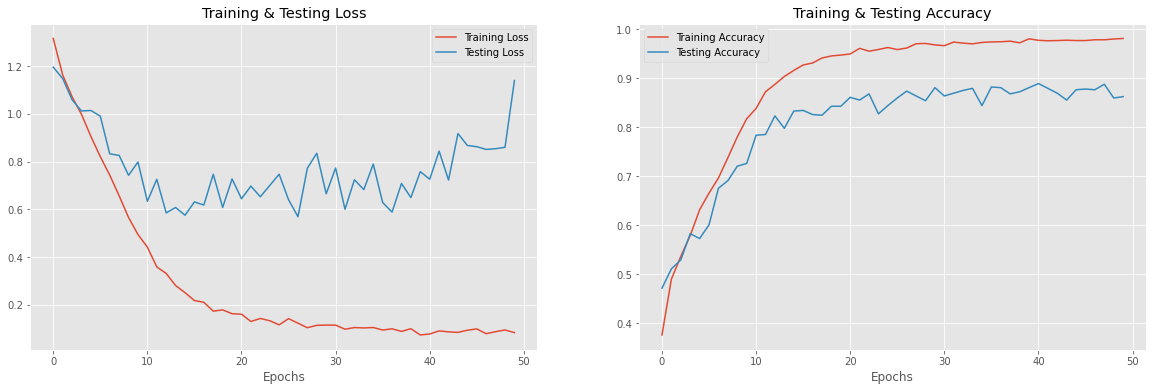

In [78]:
print("Accuracy of our model on test data : " , ara_model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history2.history['acc']
train_loss = history2.history['loss']
test_acc = history2.history['val_acc']
test_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()